In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher
from matplotlib.lines import Line2D
import numpy as np
import netCDF4 as nc
%matplotlib inline
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.family'] = 'Dejavu Serif'
plt.rcParams['font.size'] = 14

In [5]:
# i/o params
loc = "/scratch/hcm7920/ambData/channelMean/"
loc2= "/scratch/hcm7920/amb0/data/"
loc3 = "/home/hcm7920/experiments/arcticMiddepthBI/plots/officialFigs/"
conc = [0,100]

# grid params
nx = 500
ny = 500
nz = 50
dy = 2000
dx = 2000

# phys params
g = 9.81
rhoConst = 1000
cellArea = (2e3)**2
sFac = 7.4e-4 * rhoConst * -g / rhoConst # for clarity

In [13]:
# load
rhoSteady = np.load(loc+"channelMeanRho.npy")
n2Steady  = np.load(loc+"channelMeanN2.npy")
saltSteady= np.load(loc+"channelMeanSalt.npy")
uSteady   = np.load(loc+"channelMeanU.npy")
vSteady   = np.load(loc+"channelMeanV.npy")
wSteady   = np.load(loc+"channelMeanW.npy")

vsBar     = np.load(loc+"channelMeanVSbar.npy")
wsBar     = np.load(loc+"channelMeanWSbar.npy")
vrBar     = np.load(loc+"channelMeanVRbar.npy")
wrBar     = np.load(loc+"channelMeanWRbar.npy")

wsBarFlx = np.load(loc+"channelMeanAdvSltFlxZ.npy")
vsBarFlx = np.load(loc+"channelMeanAdvSltFlxY.npy")

saltForcing = np.load(loc+"channelMeanSaltForcing.npy")
UmomForcing = np.load(loc+"channelMeanUmomForcing.npy")
VmomForcing = np.load(loc+"channelMeanVmomForcing.npy")
saltTend    = np.load(loc+"channelMeanSaltTendency.npy")

diffSalt = np.load(loc+"channelMeanDiffSaltIbar.npy")
diffSalt /= cellArea

ghatSalt = np.load(loc+"channelMeanNonLocal.npy")
ghatSalt /= cellArea

levs = nc.Dataset(loc2+"grid.nc")["Z"][:]
levFaces = nc.Dataset(loc2+"grid.nc")["Zp1"][:]
deltaFaces = nc.Dataset(loc2+"grid.nc")["drF"][:]
deltaCentr = nc.Dataset(loc2+"grid.nc")["drC"][:]

In [14]:
# interpolate wsBarFlx to cell centers
wsBarFlx = np.pad(wsBarFlx,((0,1),(0,0),(0,0)),mode='constant',constant_values=0)
wsBarFlx = (wsBarFlx[:-1,:,:]+wsBarFlx[1:,:,:])/2

In [15]:
# interpolate vsBarFlx to cell centers
vsBarFlx = (vsBarFlx[:,1:,:]+vsBarFlx[:,:-1,:])/2

# interpolate vSteady to cell centers
vSteady = (vSteady[:,1:,:]+vSteady[:,:-1,:])/2

In [16]:
# calculate correlation terms
wsPrimeBar = wsBarFlx/cellArea - (wSteady*saltSteady)
vsPrimeBar = vsBarFlx/(dx*deltaFaces[:,None,None]) - (vSteady*saltSteady)


In [42]:
# calculate grad s, grid doesn't change here
sDz = np.gradient(saltSteady,levs.data,axis=(0,),edge_order=2)
sDy = np.gradient(saltSteady,dy,axis=(1,),edge_order=2)

In [48]:
# project v's' onto grad b
diabaticFlux = (vsPrimeBar*sDy) + (wsPrimeBar*sDz)
normGradS = (sDy**2 + sDz**2)**(1/2)
diabaticFlux = diabaticFlux / normGradS
diabaticFluxY = diabaticFlux * sDy / normGradS
diabaticFluxZ = diabaticFlux * sDz / normGradS

# remove diabaticFlux from total and recast all as vectors
adiaFlux = np.array((vsPrimeBar-diabaticFluxY,
                     wsPrimeBar-diabaticFluxZ))
diabaticFlux = np.array((diabaticFluxY,diabaticFluxZ))

In [49]:
# save arrays for use elsewhere
np.save(loc+"channelMeanAdiaAdvFlux.npy",adiaFlux)
np.save(loc+"channelMeanDiabaticAdvFlux.npy",diabaticFlux)


In [76]:
# simple test to see max error
test1 = adiaFlux+diabaticFlux
test2 = np.abs(np.array((vsPrimeBar,wsPrimeBar))-test1)
test2.max()

3.519752768086639e-19

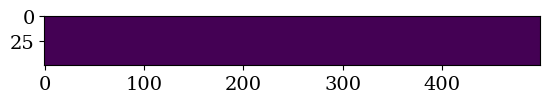

In [83]:
plt.imshow(vsBarFlx[:,::,3])